# 🏡 Boston House Price Prediction
Dette prosjektet bruker maskinlæring for å predikere boligpriser i Boston.
Jeg tester flere modeller og optimaliserer ytelsen med **XGBoost**.

## 📌 Innhold:
1. Laste inn datasettet
2. Feature Engineering
3. Datautforskning (korrelasjon og visualisering)
4. Forberede data (standardisering og splitting)
5. Trene og optimalisere XGBoost-modellen
6. Evaluering av modellen


## Importere nødvendige biblioteker
Jeg bruker Pandas for databehandling, Seaborn og Matplotlib for visualisering,  
og Scikit-learn og XGBoost for maskinlæringsmodellene.


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

## 📂 Laste inn datasettet
Datasettet inneholder informasjon om boligpriser i Boston.  
Jeg gir kolonnene beskrivende navn for å gjøre analysen enklere.


In [7]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
                'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

dataset = pd.read_csv('housing.csv', header=None, names=column_names, sep='\\s+')
dataset.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## 🔬 Feature Engineering
For å forbedre modellen lager jeg nye features basert på eksisterende informasjon.


In [10]:
dataset['TAX_per_ROOM'] = dataset['TAX'] / dataset['RM']
dataset['AGE_per_DIS'] = dataset['AGE'] / dataset['DIS']
dataset['LSTAT_squared'] = dataset['LSTAT'] ** 2
dataset['log_CRIM'] = np.log1p(dataset['CRIM'])
dataset[['TAX_per_ROOM', 'AGE_per_DIS', 'LSTAT_squared', 'log_CRIM']].head()

,TAX_per_ROOM,AGE_per_DIS,LSTAT_squared,log_CRIM
0,45.019011,15.941320,24.8004,0.006300
1,37.688834,15.884520,83.5396,0.026944
2,33.681280,12.300940,16.2409,0.026924
3,31.723350,7.555013,8.6436,0.031857
4,31.061984,8.940649,28.4089,0.066770


## 📊 Korrelasjon og Visualisering
Jeg visualiserer korrelasjonen mellom variablene for å forstå hvilke faktorer  
som har størst påvirkning på boligprisene.


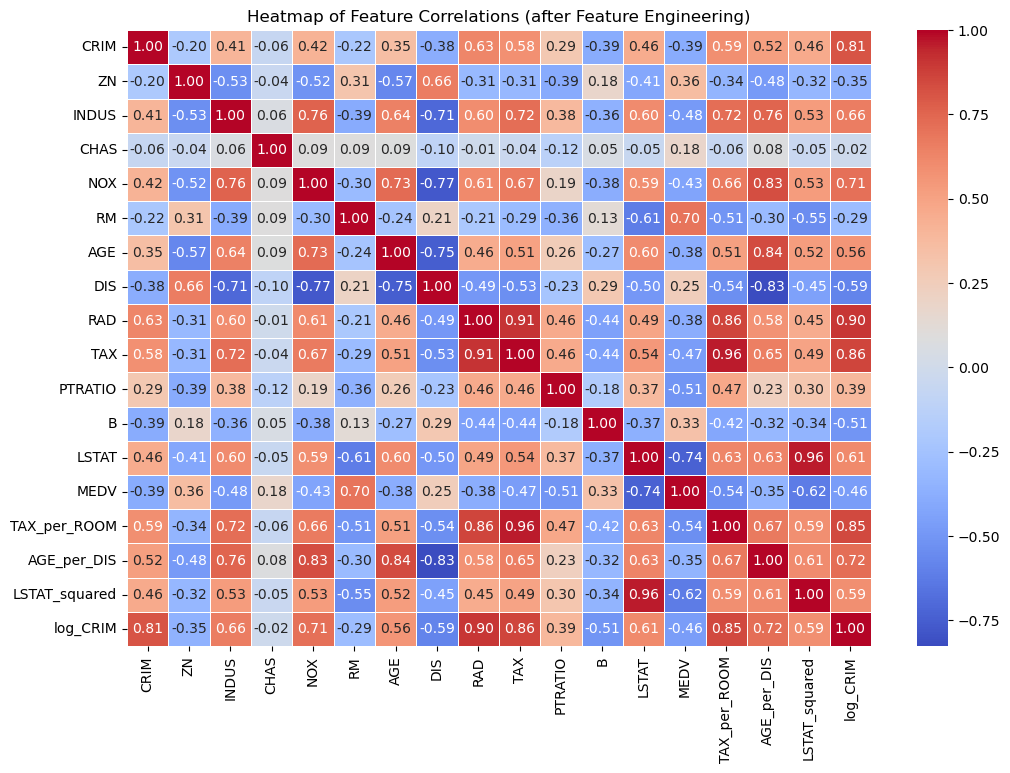

In [13]:
plt.figure(figsize=(12, 8))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Feature Correlations (after Feature Engineering)")
plt.show()

In [15]:
dataset.drop(columns=['RAD', 'CRIM'], inplace=True)

## 📌 Standardisering og datasplitting
For å gjøre modellen mer robust standardiserer jeg alle features bortsett fra `MEDV`.  
Deretter deler jeg dataene i et treningssett og et testsett (80/20).


In [18]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataset.drop(columns=['MEDV']))
scaled_dataset = pd.DataFrame(scaled_features, columns=dataset.drop(columns=['MEDV']).columns)
scaled_dataset['MEDV'] = dataset['MEDV']
X = scaled_dataset.drop(columns=['MEDV'])
y = scaled_dataset['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## 🚀 Trene og optimalisere XGBoost
Jeg bruker Grid Search for å finne de optimale hyperparametrene for XGBoost.


In [21]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = XGBRegressor(random_state=0)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
print("Beste hyperparametere:", grid_search.best_params_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Beste hyperparametere: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


## 📈 Evaluering av modellen
Jeg evaluerer modellen basert på **Mean Absolute Error (MAE)**, **Mean Squared Error (MSE)**  
og **R²-score** for å se hvor godt den predikerer boligprisene.


In [23]:
y_pred = best_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Optimalisert XGBoost med Feature Engineering:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R2 Score: {r2:.2f}")


Optimalisert XGBoost med Feature Engineering:
Mean Absolute Error (MAE): 2.68
Mean Squared Error (MSE): 19.60
R2 Score: 0.76
